In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

data_dir = "/content/drive/MyDrive/Datasets/Lazy Landmark Dataset/All"

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE, # Specify image size here
    interpolation='nearest',
    validation_split=0.2,
    subset='training',
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE, # Specify image size here
    interpolation='nearest',
    validation_split=0.2,
    subset='validation',
    seed=42
)

num_classes = len(train_ds.class_names)

Found 216 files belonging to 4 classes.
Using 173 files for training.
Found 216 files belonging to 4 classes.
Using 43 files for validation.


In [3]:
import os
import tensorflow as tf

print("Checking for problematic image files:")

def is_valid_image(filepath):
    try:
        img = tf.io.read_file(filepath)
        tf.image.decode_image(img, channels=3)  # Attempt to decode the image
        return True
    except Exception:
        return False

problematic_files = []

# Get the class names from the training dataset
class_names = train_ds.class_names

# Get a list of all file paths in the dataset directory
all_filepaths = []
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_dir):
        filepath = os.path.join(class_dir, filename)
        all_filepaths.append(filepath)

# Iterate through each file path and check if it's a valid image
for filepath in all_filepaths:
    if not is_valid_image(filepath):
        print(f"Problematic file found: {filepath}")
        problematic_files.append(filepath)

if not problematic_files:
    print("No problematic image files found.")
else:
    print(f"\nFound {len(problematic_files)} problematic files.")
    print("Please inspect these files and ensure they are valid images.")

Checking for problematic image files:
No problematic image files found.


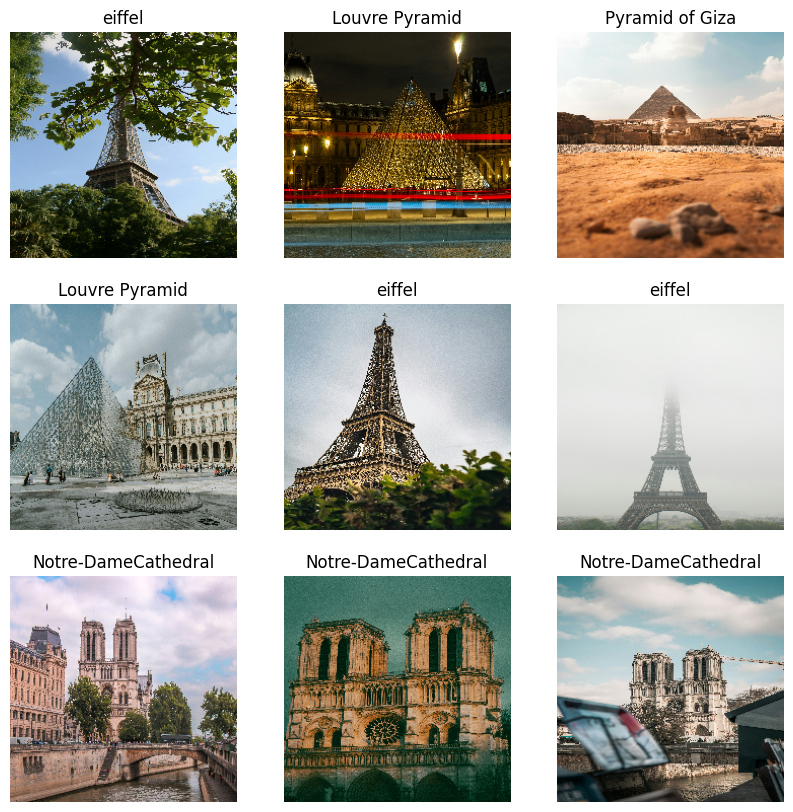

In [4]:
# Get a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")
    plt.show()

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.1),
    RandomZoom(height_factor=0.1, width_factor=0.1),
])

def augment(image, label):
  image = data_augmentation(image)
  return image, label

train_ds = train_ds.map(augment)

In [7]:
from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 model with pre-trained ImageNet weights
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,),
                         include_top=False,
                         weights='imagenet')

# Make the loaded model's layers non-trainable
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import Sequential

global_average_layer = GlobalAveragePooling2D()

prediction_layer = Dense(num_classes)

model = Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [9]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
EPOCHS = 30 # Define the number of epochs for training
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.2296 - loss: 1.5003 - val_accuracy: 0.3023 - val_loss: 1.2922
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - accuracy: 0.3030 - loss: 1.3474 - val_accuracy: 0.5116 - val_loss: 1.0649
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step - accuracy: 0.4884 - loss: 1.1866 - val_accuracy: 0.5349 - val_loss: 1.0250
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - accuracy: 0.5664 - loss: 1.0451 - val_accuracy: 0.5349 - val_loss: 0.9544
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - accuracy: 0.6826 - loss: 0.8646 - val_accuracy: 0.7209 - val_loss: 0.8489
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.6864 - loss: 0.8838 - val_accuracy: 0.6977 - val_loss: 0.8290
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 381ms/step - accuracy: 0.6752 - loss: 0.8206 - val_accuracy: 0.7209 - val_loss: 0.7938
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step - accuracy: 0.7607 - loss: 0.7517 - val_accuracy: 0.7209 - val_loss: 0

In [10]:
# Evaluate the model on the validation dataset
loss, accuracy = model.evaluate(val_ds)

# Print the evaluation results
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7512 - loss: 0.7093
Validation Loss: 0.676937997341156
Validation Accuracy: 0.7674418687820435


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


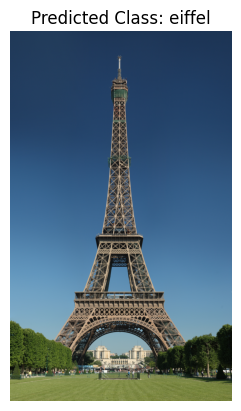

In [13]:
import matplotlib.pyplot as plt

# Function to load and preprocess an image
def load_and_preprocess_image(image_path, img_size):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img

image_path_for_prediction = '/content/eiffel.jpg'

# Load and preprocess the image
preprocessed_image = load_and_preprocess_image(image_path_for_prediction, IMG_SIZE)

# Make a prediction
predictions = model.predict(preprocessed_image)

# The predictions are logits, so we need to convert them to probabilities and get the predicted class
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]

try:
    class_names = temp_train_ds_for_classes.class_names
except NameError:
     temp_train_ds_for_classes = tf.keras.utils.image_dataset_from_directory(
        directory=data_dir,
        labels='inferred',
        label_mode='int',
        image_size=IMG_SIZE,
        interpolation='nearest',
        validation_split=0.2,
        subset='training',
        seed=42,
        verbose=False # Suppress the output
    )
     class_names = temp_train_ds_for_classes.class_names


predicted_class_name = class_names[predicted_class_index]

# Display the image and predicted label
img_display = tf.keras.utils.load_img(image_path_for_prediction)
plt.imshow(img_display)
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis("off")
plt.show()